In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import psutil

import torch

In [2]:
import torch
import torch.nn as nn

In [3]:
##### building the model architecture

#### 2d dwt transform operation 
def dwt(x) :
    
    x01 = x[:,:,0::2,:]/2
    x02 = x[:,:,1::2,:]/2
    x1 = x01[:,:,:,0::2]
    x2 = x01[:,:,:,1::2]
    x3 = x02[:,:,:,0::2]
    x4 = x02[:,:,:,1::2]
    x_LL = x1 + x2 + x3 + x4
    x_LH = -x1 -x2 + x3 + x4
    x_HL = -x1 + x2 -x3 + x4
    x_HH = x1 -x2 -x3 + x4
    return x_LL,torch.cat([x_LH,x_HL,x_HH],1)


In [4]:
#### DWT modules 
class DWT(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.requires_grad = False 
    def forward(self,x) :
        return dwt(x)
    
    

In [5]:
class DWT_down(nn.Module) :
    def __init__(self,in_c,out_c) :
        super().__init__()
        self.conv_block = nn.Sequential(nn.Conv2d(in_c,out_c,kernel_size = 4 ,stride = 2, padding = 1,bias = True),
                                        nn.BatchNorm2d(out_c),
                                        nn.LeakyReLU(0.2,inplace = True)
        )
    def forward(self,x)  :
        x = self.conv_block(x)
        return x


In [6]:
#### DWT Module
class DWT_up_bottom(nn.Module) :
    def __init__(self,in_c,out_c) :
        super().__init__()
        self.conv_block = nn.Sequential(nn.ConvTranspose2d(in_c,out_c,kernel_size = 3,stride = 1 , padding = 1,bias = True),
                                        nn.BatchNorm2d(out_c),
                                        nn.ReLU()
                                       )
    def  forward(self,x)    :
        x = self.conv_block(x)
        return x
     

In [7]:
class DWT_up(nn.Module)   :
    def __init__(self,in_c,out_c) :
        super().__init__()
        self.conv_block = nn.Sequential(nn.ConvTranspose2d(in_c,out_c,kernel_size = 4 ,stride = 2 , padding = 1,bias = True),
                                        nn.BatchNorm2d(out_c),
                                        nn.ReLU()
                                       )
    def  forward(self,x)    :
        x = self.conv_block(x)
        return x
    

In [8]:
### initial and dwt 1x1 convolution blocks
class init_conv(nn.Module) :
    def __init__(self,in_c,out_c) :
        super().__init__()
        self.conv_block = nn.Sequential(nn.Conv2d(in_c,out_c,kernel_size =  3,stride = 1, padding = 1),
                                        nn.BatchNorm2d(out_c),
                                        nn.LeakyReLU(0.2,inplace = True)
        )
    def forward(self,x)  :
        x = self.conv_block(x)
        return x


In [9]:
class conv_1x1_down(nn.Module) :
    def __init__(self,in_c,out_c ):
        super().__init__()
        self.conv_block = nn.Sequential(nn.Conv2d(in_c,out_c,kernel_size = 1,stride = 1,padding = 0))
                 
    def forward(self,x) :
        
        x = self.conv_block(x) 
        return x

In [10]:
def special(x) :
    for  i in range(31) :
        x = torch.cat([x,x],1)
    return  x    
        
    
class special_block(nn.Module):
    def __init__(self) :
        super().__init__()
        self.requires_grad = False
    def forward(self,x) :
        return special(x)

In [11]:
class conv_1x1_up(nn.Module) :
    def __init__(self,in_c,out_c) :
        super().__init__()
        self.conv_block = nn.Sequential(nn.Conv2d(in_c,out_c,kernel_size = 1,stride = 1,padding = 0),
                                       nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True))
    def forward(self,x)   :
        x = self.conv_block(x)
        return x

In [12]:
#### attention module space and channel attention block


     ### defining maxpool operation
def maxip(x):
  conv = nn.MaxPool2d(kernel_size = x.shape[2], stride = 1)
  return conv(x)

## defining average pool
def avgop(x) :
  conv = nn.AvgPool2d(kernel_size = x.shape[2],stride =1)
  return conv(x)   


In [13]:
class chann_Att(nn.Module) :
  def __init__(self,in_c) :
    super().__init__()

    self.conv_block = nn.Conv2d(in_c,int(in_c/4),kernel_size = (2,1),stride = 1)
    self.conv_block1 = nn.Sequential( nn.Conv2d(int(in_c/4),in_c,kernel_size = 1,stride = 1))
                                    
  def forward(self,x) :
      x1 = maxip(x)
      x2 = avgop(x)
      x_ = torch.cat([x1,x2],2)
      y1 = self.conv_block(x_)
      out = self.conv_block1(y1)
      return out

In [14]:
class  MeanO_weight(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.requires_grad = False
    def forward(self,x) :
        
        padding_input = nn.ZeroPad2d(1);
        x_new = padding_input(x)
        x_new.shape  ### 32,256,7,7
        x_2shape = (x.shape[0],1,x.shape[2],x.shape[3])  
        x_2 = torch.zeros(x_2shape)
        for i in range(x.shape[0]) :
            for j in range(x.shape[2]) :
                for k in range(x.shape[3]) :
                    h_start = j;
                    h_end = j+3;
                    w_start = k;
                    w_end =  k +3;
                    x_s = x_new[i,:,h_start : h_end,w_start: w_end]
                    x_2[i,:,j,k] = torch.mean(x_s);
        return x_2

In [15]:
#### function for finding spacial weight using max operation
class MaxO_weight(nn.Module) :
  def __init__(self) :
      super().__init__() 
      self.requires_grad = False
  def forward(self,x) :
      padding_input = nn.ZeroPad2d(1);
      x_new = padding_input(x)
      x_new.shape  ### 32,256,7,7
      x_1shape = (x.shape[0],1,x.shape[2],x.shape[3])  
      x_1 = torch.zeros(x_1shape)
      for i in range(x.shape[0]) :
          for j in range(x.shape[2]) :
              for k in range(x.shape[3]) :
                  h_start = j
                  h_end = j+3
                  w_start = k
                  w_end =  k +3
                  x_s = x_new[i,:,h_start : h_end,w_start: w_end]
                  x_1[i,:,j,k] = torch.max(x_s)
      return x_1


In [16]:
class spacial_pool(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.requires_grad = False
    def forward(self,x) :
        return torch.cat([torch.max(x,1)[0].unsqueeze(1),torch.mean(x,1).unsqueeze(1)],1)

In [17]:
class space_Att(nn.Module) :
  def __init__(self) :
    super().__init__()
    self.maxiO = MaxO_weight()
    self.meanO = MeanO_weight()  
    self.pool_Att = spacial_pool()   

      
    self.conv_block1 = nn.Conv2d(2,10, kernel_size = 3 ,padding = 1,stride = 1)
    self.conv_block2 = nn.Sequential(nn.BatchNorm2d(10),
                                nn.ReLU(),
                                nn.Conv2d(10,1,kernel_size =3 ,padding =1 ,stride = 1),
                                nn.Sigmoid()

    )
  def forward(self,x) :
      x1 = self.pool_Att(x)
      x2 = self.conv_block1(x1)
      out = self.conv_block2(x2)
      return out


In [18]:
class CSAB(nn.Module) :
  def __init__(self,in_c) :
    super().__init__()
    self.channel_Att = chann_Att(in_c)
    self.space_Att = space_Att()
  def forward(self,x) :
    x1 = self.channel_Att(x)
    x2 = self.space_Att(x)
    out1 = torch.mul(x,x1)
    out2 = torch.mul(x,x2)
    out3 = torch.mul(out1,x2)
    return out3


In [19]:
#### architecture of model
class model_image_reconst(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.first = init_conv(1,32)
        self.DWT = DWT()
        self.down1 = DWT_down(32,64)
        self.down2 = DWT_down(128,128)
        self.down3 = DWT_down(256,256)
        self.second = init_conv(512,512)
        self.bottom = DWT_up_bottom(512,512)
        self.up1 = DWT_up(1024,256)
        self.up2 = DWT_up(768,128)
        self.up3 = DWT_up(384,64)
        self.third = init_conv(512,512)
        self.down_low_f1 = conv_1x1_down(32,64)
        self.down_low_f2 = conv_1x1_down(128,128)
        self.down_low_f3 = conv_1x1_down(256,256)
        self.up_high_f3 = conv_1x1_up(3*256,256)
        self.up_high_f2 = conv_1x1_up(3*128,128)
        self.up_high_f1 = conv_1x1_up(3*32,64)
        self.zero_pad = nn.ZeroPad2d(2)
        self.cs_Att1_low = CSAB(32)
        self.cs_Att1_high = CSAB(96)
        
        self.cs_Att2_low = CSAB(128)
        self.cs_Att2_high = CSAB(3*128)
        self.cs_Att3_low = CSAB(256)
        self.cs_Att3_high = CSAB(3*256)
        
        self.tail_0 = nn.Sequential(nn.Conv2d(128,32,kernel_size = 5 , stride  = 1,padding =0),
                                   nn.BatchNorm2d(32),
                                   nn.ReLU())
        self.tail_1 = nn.Sequential(nn.Conv2d(64,32,kernel_size = 3 , stride  = 1,padding =1),
                                   nn.BatchNorm2d(32),
                                   nn.ReLU())
        self.tail_01 = nn.Sequential(nn.Conv2d(32,32,kernel_size = 3 , stride  = 1,padding =1),
                                   #nn.BatchNorm2d(32)
                                   nn.ReLU())
        self.tail_2 = nn.Conv2d(32,1,kernel_size = 3, stride = 1,padding  = 1)
        self.conv_13 = nn.ConvTranspose2d(256,256,kernel_size = 3, stride  = 1, padding  = 1)
        self.tanh = nn.Tanh()
        self.last = nn.Sequential(nn.Conv2d(2,1,kernel_size = 1,stride =1 ,padding = 0),nn.ReLU())
        self.special = special_block()
        
    def forward(self,x)  :
        
        x_1 = self.first(x)
        x1 = self.zero_pad(x_1)
        
        low_f1 ,high_f1 = self.DWT(x1)
        #low_f1 = self.cs_Att1_low(low_f1)
        high_f1 = self.cs_Att1_high(high_f1)
        
        low_f1 = self.down_low_f1(low_f1)
        
        x2 = self.down1(x1)
        
        x2 = torch.cat([x2,low_f1],1)
        
        low_f2,high_f2 = self.DWT(x2)
       # low_f2 = self.cs_Att2_low(low_f2)
        high_f2 = self.cs_Att2_high(high_f2)
        low_f2 = self.down_low_f2(low_f2)
        x3 = self.down2(x2)
        x3 = torch.cat([x3,low_f2],1)
        #print(x3.shape)
        low_f3,high_f3 = self.DWT(x3)
       # low_f3 = self.cs_Att3_low(low_f3)
        high_f3 = self.cs_Att3_high(high_f3)        
        low_f3 = self.down_low_f3(low_f3)
        x4 = self.down3(x3)
        x4 = torch.cat([x4,low_f3],1)
        x5 = self.second(x4)
        y0 = self.bottom(x5)
        y0 = torch.cat([y0,x4],1)
        y1 = self.up1(y0)
        high_f3 = self.up_high_f3(high_f3)
        high_f3 = self.conv_13(high_f3)
        y1 = torch.cat([y1,high_f3,x3],1)
        y2 = self.up2(y1)
        high_f2 = self.up_high_f2(high_f2)
        y2 = torch.cat([y2,high_f2,x2],1)
        y3 = self.up3(y2)
        high_f1 = self.up_high_f1(high_f1)
        y3 = torch.cat([y3,high_f1],1)
        #print(y3.shape)
        y4 = self.tail_0(y3)
        #print(y4.shap(e)
        y4 = torch.cat([y4 , x_1],1)
        y5 = self.tail_1(y4)
        
        
        y6 = self.tail_01(y5)
        out = self.tail_2(y6)
        out = torch.cat([out,x],1)
        out = self.last(out)
        
        
        return out
        
        


In [20]:
####### loading the data set
from  glob import glob
import os
train_x = sorted(glob("C:/Users/Pawan/Documents/pavan_data_500/train/images/*"))

In [21]:
train_y = sorted(glob("C:/Users/Pawan/Documents/pavan_data_500/train/grdtruth/*"))
train_y[:7]

['C:/Users/Pawan/Documents/pavan_data_500/train/grdtruth\\gtruth_0001.png',
 'C:/Users/Pawan/Documents/pavan_data_500/train/grdtruth\\gtruth_0002.png',
 'C:/Users/Pawan/Documents/pavan_data_500/train/grdtruth\\gtruth_0003.png',
 'C:/Users/Pawan/Documents/pavan_data_500/train/grdtruth\\gtruth_0004.png',
 'C:/Users/Pawan/Documents/pavan_data_500/train/grdtruth\\gtruth_0005.png',
 'C:/Users/Pawan/Documents/pavan_data_500/train/grdtruth\\gtruth_0006.png',
 'C:/Users/Pawan/Documents/pavan_data_500/train/grdtruth\\gtruth_0007.png']

In [22]:






test_y = sorted(glob("C:/Users/Pawan/Documents/pavan_data_500/test/grdtruth/*"))
test_x = sorted(glob("C:/Users/Pawan/Documents/pavan_data_500/test/images/*"))

In [23]:
###### dataloader 
from PIL import Image ,ImageOps
from torch.utils.data import Dataset,DataLoader
class DWT_dataset(Dataset) :
    def __init__(self,image_path,gtr_path) :
        self.image_path = image_path
        self.gtr_path = gtr_path
    def __len__(self)    :
        return len(self.image_path)
    def __getitem__(self,idx) :
        image = Image.open(self.image_path[idx])
    
        image = np.expand_dims(image,axis = 0)
        image = image.astype(np.float32)
        image = image
        image = torch.from_numpy(image)
        gtr = Image.open(self.gtr_path[idx])
        gtr = np.expand_dims(gtr,axis = 0)
        gtr = gtr.astype(np.float32)
        gtr = gtr
        gtr = torch.from_numpy(gtr)
        return image, gtr

In [24]:
### creation of dataset

train_dataset = DWT_dataset(train_x,train_y)
test_dataset = DWT_dataset(test_x,test_y)

train_x[5],train_y[5]

('C:/Users/Pawan/Documents/pavan_data_500/train/images\\train_0006.png',
 'C:/Users/Pawan/Documents/pavan_data_500/train/grdtruth\\gtruth_0006.png')

In [25]:
#### dataloader
epochs = 25
batch_size = 40
train_loader = DataLoader(dataset = train_dataset,batch_size = batch_size)

len(train_dataset)


4200

In [26]:
test_loader = DataLoader(dataset = test_dataset,shuffle = False,batch_size = batch_size )
device = 'cuda' 
loss_fn = nn.L1Loss()
lr = 0.001

In [27]:
model1 = model_image_reconst()
model1 = model1.to(device)


In [28]:
import random
def seeding(seed) :
  random.seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

In [29]:
optimizer = torch.optim.Adam(model1.parameters(),lr,betas =( 0.5,0.8),weight_decay = 0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min',patience = 5,verbose = True)
model_params_path = "C:/Users/Pawan/Documents/pavan_data_500/model_parameters2.pth"
model_params_trainpath = "C:/Users/Pawan/Documents/pavan_data_500/model_parameters3.pth"

In [30]:
##### training and validating
def train(model,loader,optimizer,loss_fn,device) :
    epoch_loss = 0.0
    model.train()
    for x,y in loader:
        
        x = x.to(device,dtype = torch.float32)
        y = y.to(device,dtype = torch.float32)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred,y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss = epoch_loss/len(loader)     
    return epoch_loss

In [31]:
#### evaluating
def evaluate(model,loader,loss_fn,device):
    epoch_loss = 0.0 
    model.eval()
    with torch.no_grad() :
        for x,y in loader :
            x = x.to(device,dtype = torch.float32)
            y = y.to(device,dtype = torch.float32)
            y_pred = model(x)
            loss = loss_fn(y_pred,y)
            epoch_loss += loss.item()
    epoch_loss = epoch_loss/len(loader)   
    
    return epoch_loss
    

In [32]:
valid_y = sorted(glob("C:/Users/Pawan/Documents/pavan_data_500/valid/grdtruth/*"))
valid_x = sorted(glob("C:/Users/Pawan/Documents/pavan_data_500/valid/images/*"))

In [33]:
##### training the model
best_valid_loss = float('inf')
best_train_loss = float('inf')
seeding(32)
for epoch in range(epochs) :
    train_loss = train(model1,train_loader,optimizer,loss_fn,device)
    valid_loss = evaluate(model1,test_loader,loss_fn,device)
    if valid_loss < best_valid_loss :
        torch.save(model1.state_dict(),model_params_path)
        best_valid_loss = valid_loss
    if train_loss < best_train_loss :
        torch.save(model1.state_dict(),model_params_trainpath)
        best_train_loss = train_loss    
    print(f"epoch  : {epoch+1 : 02}|| trainloss : {train_loss}  || validloss : {valid_loss} ")    
    
    

epoch  :  1|| trainloss : 97.56579201107934  || validloss : 10.772368812561036 
epoch  :  2|| trainloss : 7.45348014831543  || validloss : 8.887883949279786 
epoch  :  3|| trainloss : 5.631039583115351  || validloss : 7.862788677215576 
epoch  :  4|| trainloss : 4.995779137384324  || validloss : 7.429006195068359 
epoch  :  5|| trainloss : 4.644725054786319  || validloss : 6.974201583862305 
epoch  :  6|| trainloss : 4.425727065404256  || validloss : 6.574645233154297 
epoch  :  7|| trainloss : 4.265022018977574  || validloss : 6.319363212585449 
epoch  :  8|| trainloss : 4.100423413231259  || validloss : 6.0309161186218265 
epoch  :  9|| trainloss : 3.914357966468448  || validloss : 5.69721622467041 
epoch  :  10|| trainloss : 3.6794032164982386  || validloss : 5.767018222808838 
epoch  :  11|| trainloss : 3.434619347254435  || validloss : 6.0711541175842285 
epoch  :  12|| trainloss : 3.2059194224221366  || validloss : 5.517566394805908 
epoch  :  13|| trainloss : 3.015331120718093  

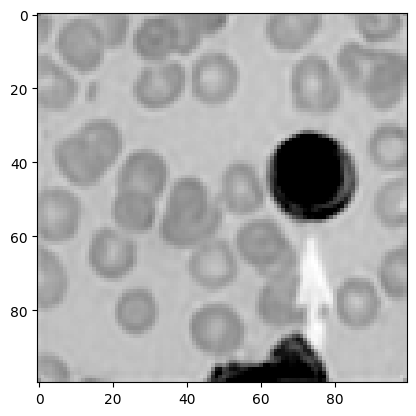

In [45]:
### testing

x_path = valid_x[4]
x =np.array(Image.open(x_path))
y_path = valid_y[4]
y = np.array(Image.open(y_path))
type(x)
#plt.subplot(1,3,1)
#plt.imshow(x,cmap = 'gray')
#plt.subplot(1,3,2)
with torch.no_grad() :
    
    model = model_image_reconst()
    model = model.to(device)
    model.eval()
    x = torch.from_numpy(x)
    x =  x[None,None,:,:]
    x = x.to(device,dtype = torch.float32)
    model.load_state_dict(torch.load(model_params_trainpath,map_location = device))
    y_pred = model(x)
    #x = torch.squeeze(x,dim = 0)
    #x = torch.squeeze(x,dim = 0)
    #x = x.cpu().numpy()
    
    y_pred = torch.squeeze(y_pred ,dim = 0)
    y_pred = torch.squeeze(y_pred ,dim = 0)
    y_pred = y_pred.cpu().numpy()
    #y_pred = np.array(y_pred,dtype =np.uint8)
    #y_pred = y_pred
    out = Image.fromarray(y_pred)
    image_rgb =  out.convert('RGB')
    image_rgb.save('DWTA_valid_4.png')
    out.show()
    
    #plt.imshow(y, cmap = 'gray')
    #plt.subplot(1,3,3)
    plt.imshow(y_pred , cmap = 'gray')
    

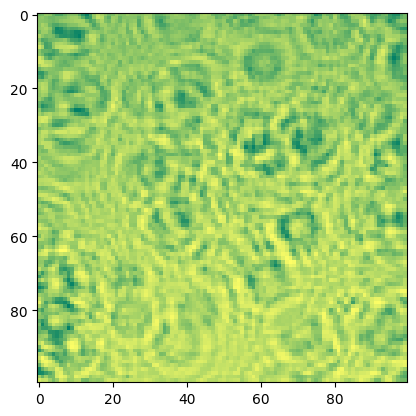

In [38]:
import matplotlib.image as mpimg


image_path = "C:/Users/Pawan/Documents/PAVAN (MTECH 22EE65R07)/MTP/pavan/mono.jpg"
mpimag_ = mpimg.imread(image_path)
#plt.imshow(mpimag_[750:1250,500:1000])
image = Image.open(image_path)
image_ = ImageOps.grayscale(image)
image__ = np.array(image_,dtype = np.float32)

imag = image__[500:1000,500:1000]
imag_ = Image.fromarray(imag)
imag_ = imag_.resize((100,100))
imag_ = np.array(imag_,dtype = np.float32)


#imag_.show()
plt.imshow(imag_,cmap = 'summer')

In [ ]:
y_n = torch.from_numpy(y.astype(np.float32))

y_n = y_n[None,None,:,:]
y_pred_n = torch.from_numpy(y_pred.astype(np.float32))
y_pred_n = y_pred_n[None,None,:,:]

import math
from math import exp
import torch
import torch.nn.functional as F

def ssim(img1, img2, window_size=11, sigma=1.5):
    # Ensure inputs are in the range [0, 1]
    img1 = torch.clamp(img1, 0, 1)
    img2 = torch.clamp(img2, 0, 1)

    # Create a Gaussian window
    window = torch.tensor(
        [[exp(-0.5 * ((i - window_size // 2) / sigma)**2 - 0.5 * ((j - window_size // 2) / sigma)**2)
          for j in range(window_size)]
         for i in range(window_size)]
    ).unsqueeze(0).unsqueeze(0).to(img1.device, dtype=img1.dtype)
    window = window / window.sum()

    # Compute mean of both images
    mu1 = F.conv2d(img1, window, padding=window_size // 2)
    mu2 = F.conv2d(img2, window, padding=window_size // 2)

    # Compute variance and covariance
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2) - mu1_mu2

    # Compute SSIM
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    # Compute mean SSIM over the image
    ssim_index = torch.mean(ssim_map)

    return ssim_index

# Example usage
img1 = torch.rand(1, 1, 100, 100)  # Example grayscale image
img2 = torch.rand(1, 1, 100, 100)  # Example grayscale image

ssim_value = ssim(y_n,y_pred_n)
print("SSIM:", ssim_value.item())


y_n.dtype

 

In [39]:
with torch.no_grad() :
    
    model = model_image_reconst()
    model = model.to(device)
    
    imag = torch.from_numpy(np.array(imag_,dtype =np.float32))
    imag =  imag[None,None,:,:]
    imag = imag.to(device,dtype = torch.float32)
    model.load_state_dict(torch.load(model_params_path,map_location = device))
    y_pred = model(imag)
    #x = torch.squeeze(x,dim = 0)
    #x = torch.squeeze(x,dim = 0)
    #x = x.cpu().numpy()
    #model.eval()
    y_pred = torch.squeeze(y_pred ,dim = 0)
    y_pred = torch.squeeze(y_pred ,dim = 0)
    y_pred = y_pred.cpu().numpy()
    #y_pred = np.array(y_pred,dtype =np.uint8)
    #y_pred = y_pred
    out = Image.fromarray(y_pred)
    print(out.mode)

    image_rgb =  out.convert('RGB')
    image_rgb.save('Attention.png')
    out.show()
    
#    plt.imshow(y_pred, cmap = 'summer')
    

F


In [ ]:
lll,hhh = dwt(x)
lll = lll.cpu().numpy()
lll = lll[0,0,:,:]
out = Image.fromarray(lll)
image_rgb =  out.convert('RGB')
image_rgb.save('LL.png')
out.show()
    
plt.imshow(lll,cmap ='gray')

In [ ]:
hhh1 = hhh[0,0,:,:]
hhh2 = hhh[0,1,:,:]
hhh3 = hhh[0,2,:,:]
hhh1 = hhh1.cpu().numpy()
out = Image.fromarray(hhh1)
image_rgb =  out.convert('RGB')
image_rgb.save('LH.png')
out.show()
plt.imshow(hhh1,cmap = 'gray')

In [ ]:
hhh2 = hhh2.cpu().numpy()
plt.imshow(hhh2,cmap = 'gray')

In [ ]:
hhh3 = hhh3.cpu().numpy()
plt.imshow(hhh3,cmap = 'gray')